09/14/22 The purpose of this file is to see if weighting the ranking will perform better (like tfidf). 

In [1]:
import os
from matplotlib import pyplot as plt
%matplotlib inline 
os.chdir("../..")
from datasets.hsqc_folder_dataset import FolderDataset
from models.compute_metrics import cm
from models.ranked_transformer import HsqcRankedTransformer
from models.ranked_double_transformer import DoubleTransformer
from datasets.hsqc_folder_dataset import FolderDataModule
import re

In [3]:
import importlib
import utils.ranker
importlib.reload(utils.ranker)
importlib.reload(utils.subtracted_ranker)
from utils.ranker import RankingSet
from utils.subtracted_ranker import SubtractingRankingSet

In [5]:
path = "/workspace/Spectre/tempdata/hyun_fp_data/hsqc_ms_pairs"
train = FolderDataset(dir = path, split="train", input_src=["HSQC"])

In [6]:
import torch
from tqdm import tqdm
def accumulate_fp(store,ds):
    ds_len = len(ds)
    for i in tqdm(range(ds_len)):
        hsqc, fp = ds[i]
        store[:] += fp
base = torch.zeros(6144)
accumulate_fp(base, train)

100%|██████████| 9794/9794 [00:04<00:00, 1962.40it/s]


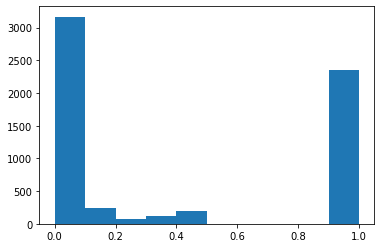

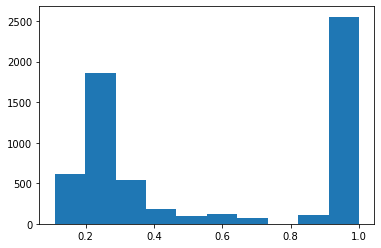

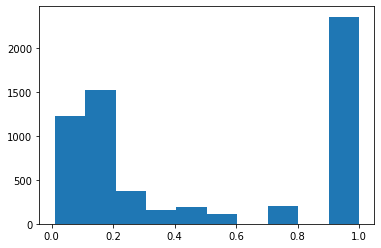

False False False


In [10]:
idf = 1/(base + 1)
log_idf = 1/torch.clamp(torch.log(base + 1 + 1e-6), min = 1, max = 100)
sqrt_idf = 1/torch.sqrt(base + 1)
avg_fp = base / len(train)

from matplotlib import pyplot as plt
plt.hist(idf.numpy())
plt.show()
plt.hist(log_idf.numpy())
plt.show()
plt.hist(sqrt_idf.numpy())
plt.show()

print(any(idf < 0), any(log_idf) < 0, any(sqrt_idf < 0))

In [22]:
import glob
folder = "/data/Spectre/pre_exp_v2/"
path = "j2_hsqc_pre*"
globs = glob.glob(os.path.join(folder, path))
assert(len(globs) == 1)
chkpt = glob.glob(os.path.join(folder, path, "checkpoints", "epoch=*"))
assert(len(globs) == 1)
full_path = chkpt[0]
print(full_path)

/data/Spectre/pre_exp_v2/j2_hsqc_pre_[09_11_2022_10:32]_[bs=128_epochs=300_lr=0.0001_heads=8_layers=8_dim_coords=112,112,32_dim_model=256_dropout=0.3_ff_dim=256_out_dim=6144_pos_weight=1.0_wavelength_bounds=None_weight_decay=0.0]/checkpoints/epoch=298-step=233818.ckpt


In [12]:
print(idf is not None, idf)
ranker = RankingSet(file_path="./tempdata/hyun_pair_ranking_set_07_22/val_pair.pt", idf_weights=idf)
ranker_log = RankingSet(file_path="./tempdata/hyun_pair_ranking_set_07_22/val_pair.pt", idf_weights=log_idf)
ranker_sqrt = RankingSet(file_path="./tempdata/hyun_pair_ranking_set_07_22/val_pair.pt", idf_weights=sqrt_idf)
ranker_sub = SubtractingRankingSet(file_path="./tempdata/hyun_pair_ranking_set_07_22/val_pair.pt", idf_weights=avg_fp)

True tensor([1.0000e+00, 3.3568e-04, 1.0000e+00,  ..., 4.0000e-02, 3.1250e-02,
        2.1739e-02])


In [13]:
model = DoubleTransformer.load_from_checkpoint(full_path).cuda()
model.eval()

DoubleTransformer(
  (hsqc): HsqcRankedTransformer(
    (enc): CoordinateEncoder()
    (fc): Linear(in_features=256, out_features=6144, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizab

In [14]:
my_dir = f"/workspace/Spectre/tempdata/hyun_fp_data/hsqc_ms_pairs"
dm = FolderDataModule(dir=my_dir, do_hyun_fp=True, input_src=["HSQC", "MS"], batch_size=128)
dm.setup("fit")
val_dl = dm.val_dataloader()

In [15]:
import tqdm
ranks = []
ranks_idf = []
ranks_idf_log = []
ranks_idf_sqrt = []
ranks_idf_sub = []
rankers = [
  (ranker, "default", ranks_idf), 
  (ranker_log, "log", ranks_idf_log), 
  (ranker_sqrt, "sqrt", ranks_idf_sqrt),
  (ranker_sub, "sub", ranks_idf_sub)
]
with torch.no_grad():
  for batch in tqdm.tqdm(val_dl):
    hsqc, ms, fp = batch
    hsqc, ms, fp = hsqc.cuda(), ms.cuda(), fp.cuda()
    out = torch.sigmoid(model.forward(hsqc, ms))
    out = (out >= 0.5).type(torch.FloatTensor)

    cts = [1, 5, 10]
    rank_res = ranker.batched_rank(out, fp)
    for r, name, li in rankers:
      rank_res_idf = r.batched_rank_tfidf(out, fp)
      li.append(rank_res_idf.float().mean().item())
    ranks.append(rank_res.float().mean().item())

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


In [19]:
print("mean_rank", torch.mean(torch.tensor(ranks)))
print("ranks_idf", torch.mean(torch.tensor(ranks_idf)))
print("ranks_log", torch.mean(torch.tensor(ranks_idf_log)))
print("ranks_sub", torch.mean(torch.tensor(ranks_idf_sub)))
print("ranks_sqrt", torch.mean(torch.tensor(ranks_idf_sqrt)))

mean_rank tensor(109.5725)
ranks_idf tensor(244.7964)
ranks_log tensor(166.4336)
ranks_sub tensor(297.8703)
ranks_sqrt tensor(202.6117)
